120000
2015-06-27T12:00:00.000000000
0.1495725651425508
0.538578611208647
0.9948455443266137
0.9982350085203202
0.9562098532568478
0.96018666
0.9848665102654142
0.9412189225597235
0.9853380270973471
0.98990095
120000
2015-08-29T12:00:00.000000000
0.45561782304217846
0.39427143
0.9948388357876736
0.99421245
0.8872430433647733
0.7907536
0.9052417275151222
0.7938828
0.9915480651593597
0.9870433
120000
2016-06-10T12:00:00.000000000
0.24115346014798297
0.12512931
0.9952933396814617
0.9980776
0.9968935694488775
0.94341683
0.9749469531378248
0.94970655
0.9824163024571293
0.98219484
0
2017-05-09T00:00:00.000000000
0.43843581824662264
0.43572515
0.9910939229445533
0.99382293
0.9859485730409789
0.9885136
0.9877454358979949
0.9798107962231195
0.9995752838929838
0.9973738
0
2017-09-22T00:00:00.000000000
0.14068653665988806
0.24136269
0.9976303940236358
0.997765300932655
0.9807997206045451
0.9350640201561471
0.9621793659189095
0.99642485
0.9997439631125068
0.9991082759306559
0
2017-09-23T00:00:00.0

Text(0.5, 1.0, 'Temperature BL Skill Score')

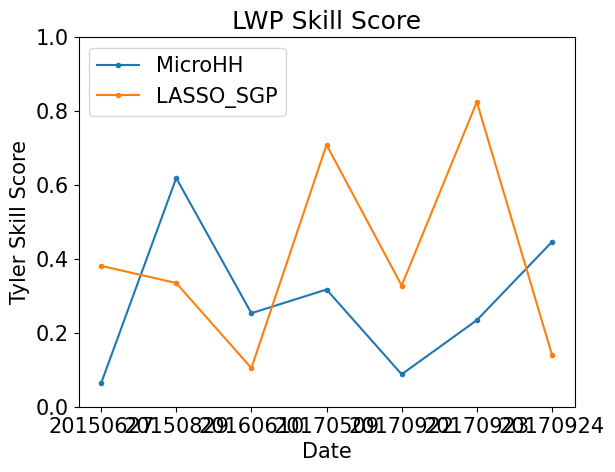

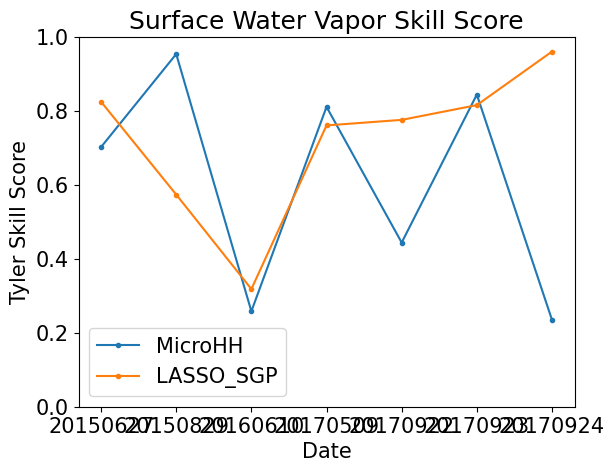

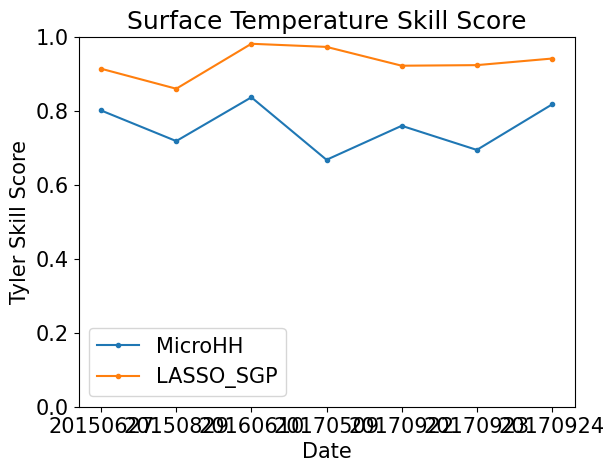

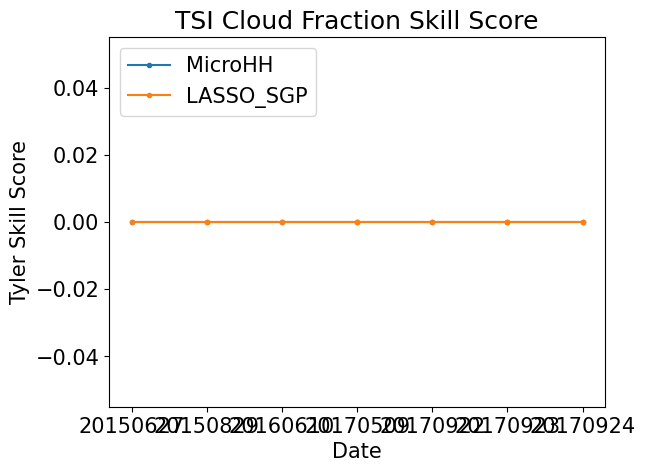

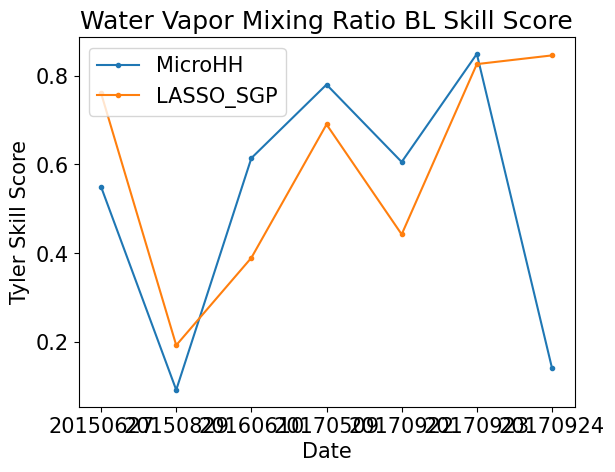

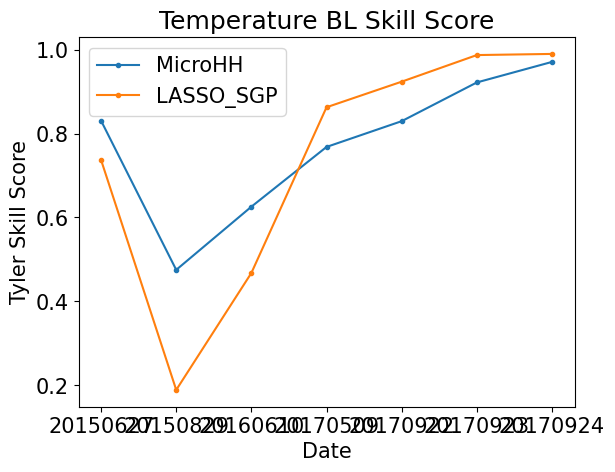

In [2]:

import xarray as xr
import matplotlib.pyplot as pl
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import os
from datetime import datetime, timedelta
import pandas as pd

dates=["20150627","20150829","20160610","20170509","20170922","20170923","20170924"]
sim='2'

lwp_tsscore=np.zeros((4,len(dates)))
Ts_tsscore=np.zeros((4,len(dates)))
qt_surf_tsscore=np.zeros((4,len(dates)))
ql_cover_tsscore=np.zeros((4,len(dates)))
qt_bl_tsscore=np.zeros((4,len(dates)))
T_bl_tsscore=np.zeros((4,len(dates)))

ncfilename='SGP.default.0000000.nc'
sgp_path=f'/fs/ess/PFS0220/LSM/SGP/SGP_obs_sim{sim}/obs_model/'

def taylor_statistics(obs,mod):
    std_relative=np.std(mod)/np.std(obs)
    r=np.corrcoef(obs,mod)[0,1]
    tss=2*(1+r)/(std_relative+1/std_relative)**2

    relative_mean=np.mean(mod)/np.mean(obs)
    if relative_mean>1:
        relative_mean=1/relative_mean
    print(relative_mean)
    total_score=np.sqrt(tss*relative_mean)
    return tss,relative_mean;

def calculate_tyler_score(mhh_var,sgp_var):
    tss=np.zeros((2))
    if mhh_var=='ql_path':
        tss[0]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:],(microhh_out_slice[mhh_var]*1000).isel(time=slice(None,None,12)).values[:])
    else:
        tss[0]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:],(microhh_out_slice[mhh_var]).isel(time=slice(None,None,12)).values[:])
    tss[1]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=1,time=slice(0,tlen_sgp)).values[:],lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:])
    return tss;
    
for i in range(len(dates)):
    ncpath=f'/fs/ess/PFS0220/LSM/SGP/SGP_{dates[i]}/'
    prefixed = [filename for filename in os.listdir(sgp_path) if filename.startswith(f'sgplassodiagobsmod{sim}C1.m1.{dates[i]}.')]
    sgpfilename=str(prefixed[0])
    print(int(sgpfilename.split('.')[3]))
    lasso_sgp=xr.open_dataset(sgp_path+sgpfilename,decode_times=True)
    tlen_sgp=len(lasso_sgp['time'].values[:])-1
    
    print(lasso_sgp['time'].isel(time=0).values)
    if int(sgpfilename.split('.')[3])==0:
        lasso_sgp=lasso_sgp.sel(time=slice(lasso_sgp['time'].isel(time=12).values,lasso_sgp['time'].isel(time=27).values))
        tlen_sgp=len(lasso_sgp['time'].values[:])-1
    else:
        t_start=0;
    

    microhh_out=xr.open_dataset(ncpath+ncfilename,decode_times=True)
    rootgroup = Dataset(ncpath+ncfilename,"r")
    for group in rootgroup.groups:
        microhh_out=xr.merge([microhh_out, xr.open_dataset(ncpath+ncfilename,group=group,decode_times=True)])
    microhh_out_slice=microhh_out.sel(time=slice(lasso_sgp['time'].isel(time=0).values,lasso_sgp['time'].values[tlen_sgp]+pd.Timedelta(minutes=10)))

    [lwp_tsscore[0,i],lwp_tsscore[2,i]]=taylor_statistics(lasso_sgp['lwp'].isel(source_type=0).values[:],(microhh_out_slice['ql_path']*1000).isel(time=slice(None,None,12)).values[:])
    [lwp_tsscore[1,i],lwp_tsscore[3,i]]=taylor_statistics(lasso_sgp['lwp'].isel(source_type=1).values[:],lasso_sgp['lwp'].isel(source_type=0).values[:])

    [Ts_tsscore[0,i],Ts_tsscore[2,i]]=taylor_statistics(lasso_sgp['temperature_surface'].isel(source_type=0).values[:],(microhh_out_slice['T']).isel(z=0,time=slice(None,None,12)).values[:])
    [Ts_tsscore[1,i],Ts_tsscore[3,i]]=taylor_statistics(lasso_sgp['temperature_surface'].isel(source_type=1).values[:],lasso_sgp['temperature_surface'].isel(source_type=0).values[:])
    
    [qt_surf_tsscore[0,i],qt_surf_tsscore[2,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=0).values[:],(microhh_out_slice['qt']*1000).isel(z=0,time=slice(None,None,12)).values[:])
    [qt_surf_tsscore[1,i],qt_surf_tsscore[3,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=1).values[:],lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=0).values[:])
    
    #ql_cover_tsscore[0,i]=taylor_statistics(lasso_sgp['cloud_fraction_tsi'].isel(source_type=0).values[:],(microhh_out_slice['ql_cover']).isel(time=slice(None,None,12)).values[:])
    #ql_cover_tsscore[1,i]=taylor_statistics(lasso_sgp['cloud_fraction_tsi'].isel(source_type=1).values[:],lasso_sgp['cloud_fraction_tsi'].isel(source_type=0).values[:])
    
    [qt_bl_tsscore[0,i],qt_bl_tsscore[2,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=0).values[:],(microhh_out_slice['qt']*1000).isel(z=slice(20,25),time=slice(None,None,12)).mean(dim='z').values[:])
    [qt_bl_tsscore[1,i],qt_bl_tsscore[3,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=1).values[:],lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=0).values[:])

    [T_bl_tsscore[0,i],T_bl_tsscore[2,i]]=taylor_statistics(lasso_sgp['temperature_boundary_layer'].isel(source_type=0).values[:],(microhh_out_slice['T']).isel(z=slice(20,25),time=slice(None,None,12)).mean(dim='z').values[:])
    [T_bl_tsscore[1,i],T_bl_tsscore[3,i]]=taylor_statistics(lasso_sgp['temperature_boundary_layer'].isel(source_type=1).values[:],lasso_sgp['temperature_boundary_layer'].isel(source_type=0).values[:])

    #pl.figure()
    #microhh_out_slice['T'].isel(z=0).plot.line(label='MicroHH')
    #lasso_sgp['temperature_surface'].isel(source_type=1).plot.line('y--',label='LASSO_SGP')
    #lasso_sgp['temperature_surface'].isel(source_type=0).plot.line('k-.',label='Observation')
    #pl.title('')
    #pl.legend(bbox_to_anchor=(0.3, 1.25),loc="upper left")

pl.figure()
pl.plot(dates,lwp_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,lwp_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="upper left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.ylim([0,1])
pl.title('LWP Skill Score')

pl.figure()
pl.plot(dates,qt_surf_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,qt_surf_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="lower left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.ylim([0,1])
pl.title('Surface Water Vapor Skill Score')

pl.figure()
pl.plot(dates,Ts_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,Ts_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="lower left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.ylim([0,1])
pl.title('Surface Temperature Skill Score')

pl.figure()
pl.plot(dates,ql_cover_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,ql_cover_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="upper left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.title('TSI Cloud Fraction Skill Score')

pl.figure()
pl.plot(dates,qt_bl_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,qt_bl_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="upper left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.title('Water Vapor Mixing Ratio BL Skill Score')

pl.figure()
pl.plot(dates,T_bl_tsscore[0,:],'.-',label='MicroHH')
pl.plot(dates,T_bl_tsscore[1,:],'.-',label='LASSO_SGP')
pl.legend(loc="upper left")
pl.ylabel('Tyler Skill Score')
pl.xlabel('Date')
pl.title('Temperature BL Skill Score')



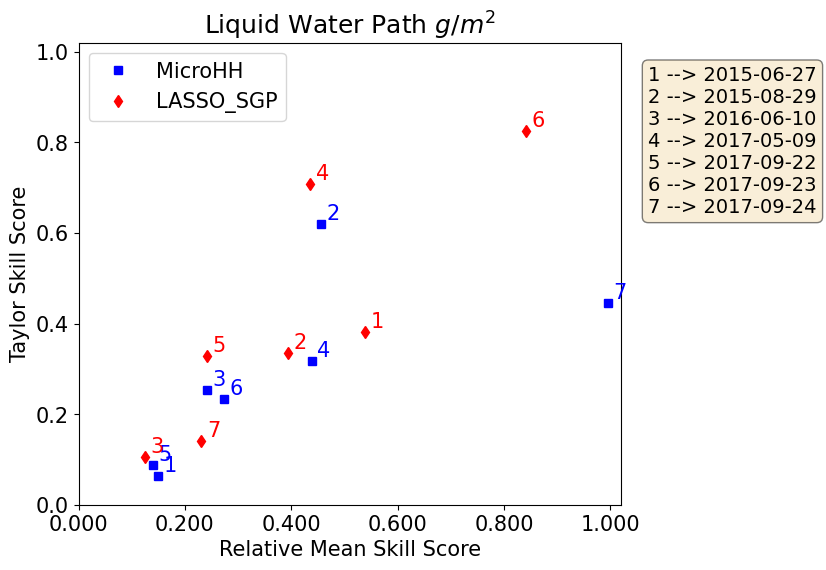

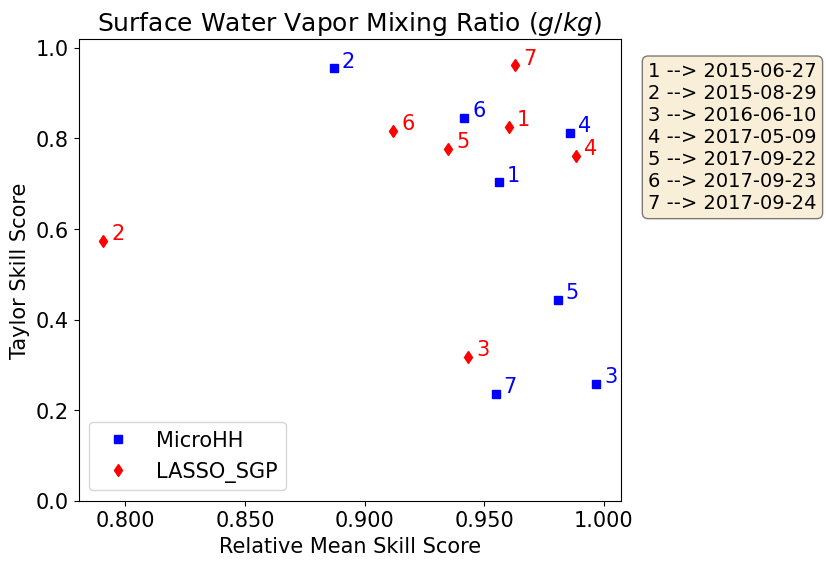

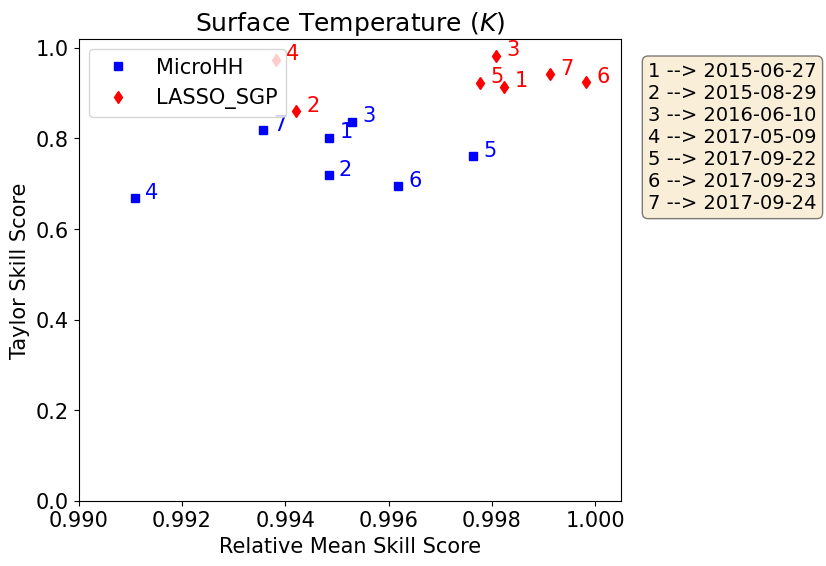

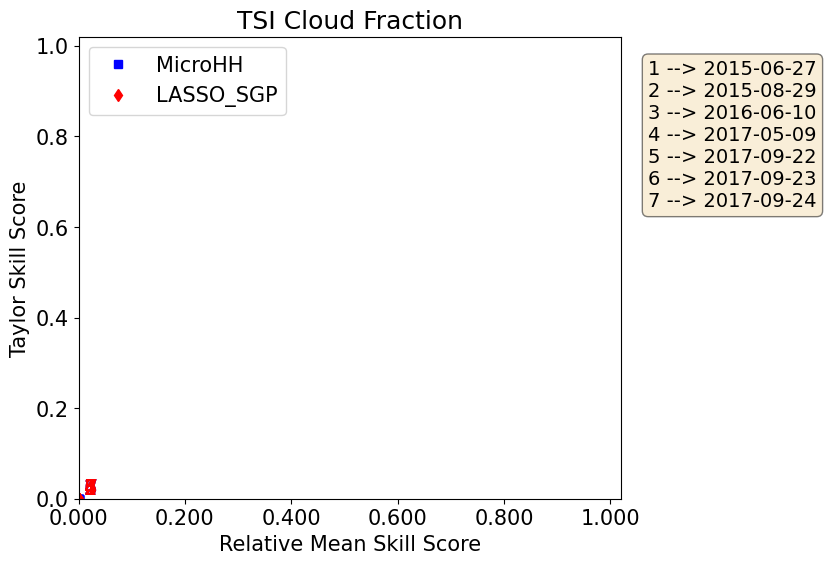

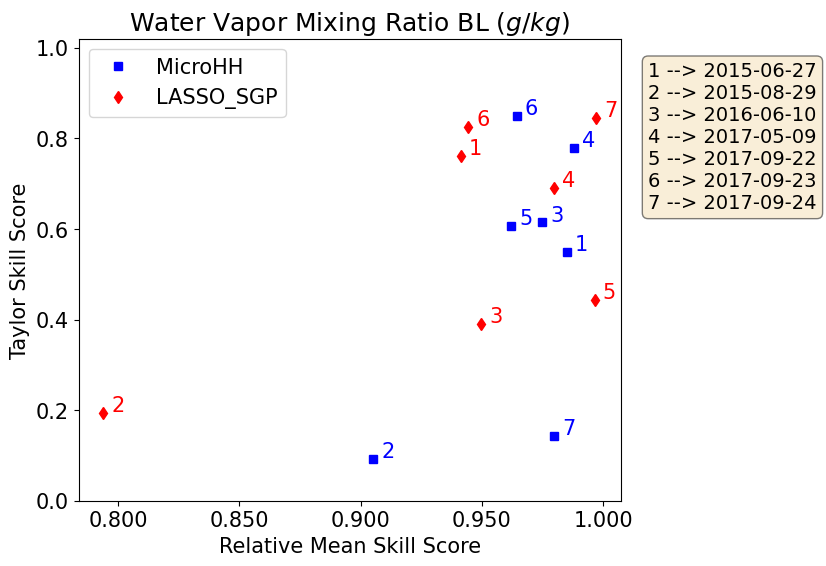

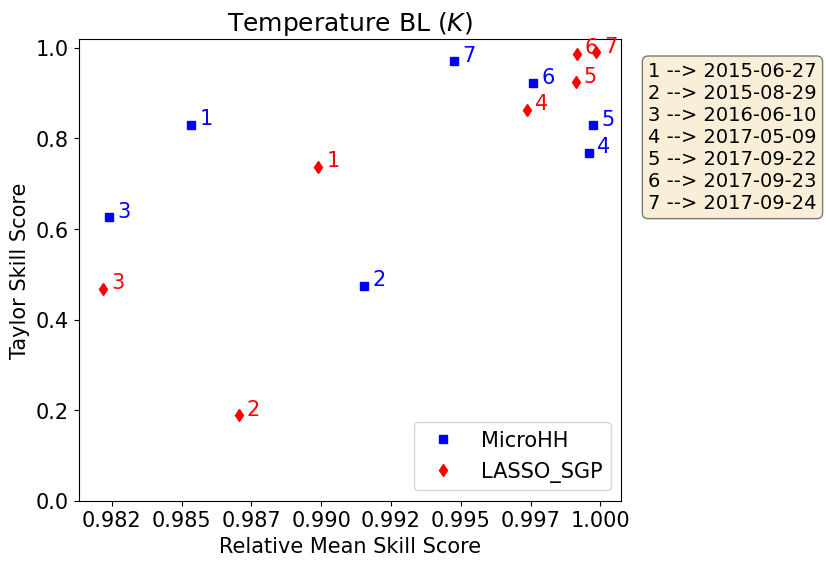

In [5]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams.update({'font.size': 15})
def scatter_figure(variable,title,legend_position):
    fig,ax = pl.subplots(figsize=(7,6))
    pl.plot(variable[2,:],variable[0,:],'bs',label='MicroHH')
    pl.plot(variable[3,:],variable[1,:],'rd',label='LASSO_SGP')
    pl.legend(loc=legend_position)
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Relative Mean Skill Score')
    pl.ylim([0,1.02])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if np.min(variable[3,:])<0.5:
        pl.xlim([0,1.02])
        an_offset = 0.01
    elif np.min(variable[3,:])>0.985:
        pl.xlim([0.99,1.0005])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        an_offset=(np.max(variable[3,:])-np.min(variable[3,:]))/30
    else:
        an_offset=(np.max(variable[3,:])-np.min(variable[3,:]))/60

    for i in range(0,len(variable[0,:])):
        pl.annotate(i+1, (variable[2,i],variable[0,i]),xytext=(variable[2,i]+an_offset,variable[0,i]+an_offset),color='b')

    for i in range(0,len(variable[0,:])):
        pl.annotate(i+1, (variable[3,i],variable[1,i]),xytext=(variable[3,i]+an_offset,variable[1,i]+an_offset),color='r')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join(('1 --> 2015-06-27','2 --> 2015-08-29','3 --> 2016-06-10','4 --> 2017-05-09','5 --> 2017-09-22','6 --> 2017-09-23','7 --> 2017-09-24'))
    ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    pl.title(title)

scatter_figure(lwp_tsscore,'Liquid Water Path $g/m^2$',"upper left")
scatter_figure(qt_surf_tsscore,'Surface Water Vapor Mixing Ratio $(g/kg)$',"lower left")
scatter_figure(Ts_tsscore,'Surface Temperature $(K)$',"upper left")
scatter_figure(ql_cover_tsscore,'TSI Cloud Fraction',"upper left")
scatter_figure(qt_bl_tsscore,'Water Vapor Mixing Ratio BL $(g/kg)$',"upper left")
scatter_figure(T_bl_tsscore,'Temperature BL $(K)$',"lower right")




In [8]:

import xarray as xr
import matplotlib.pyplot as pl
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import os
from datetime import datetime, timedelta
import pandas as pd

dates=["20150627","20150829","20160610","20170509","20170922","20170923","20170924"]
sim='2'

lwp_tsscore=np.zeros((4,len(dates)))
Ts_tsscore=np.zeros((4,len(dates)))
qt_surf_tsscore=np.zeros((4,len(dates)))
ql_cover_tsscore=np.zeros((4,len(dates)))
qt_bl_tsscore=np.zeros((4,len(dates)))
T_bl_tsscore=np.zeros((4,len(dates)))

ncfilename='SGP.default.0000000.nc'
sgp_path=f'/fs/ess/PFS0220/LSM/SGP/SGP_obs_sim{sim}/obs_model/'

def taylor_statistics(obs,mod):
    std_relative=np.std(mod)/np.std(obs)
    r=np.corrcoef(obs,mod)[0,1]
    tss=2*(1+r)/(std_relative+1/std_relative)**2

    relative_mean=np.mean(mod)/np.mean(obs)
    if relative_mean>1:
        relative_mean=1/relative_mean
    total_score=np.sqrt(tss*relative_mean)
    return tss,relative_mean;

def calculate_tyler_score(mhh_var,sgp_var):
    tss=np.zeros((2))
    if mhh_var=='ql_path':
        tss[0]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:],(microhh_out_slice[mhh_var]*1000).isel(time=slice(None,None,12)).values[:])
    else:
        tss[0]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:],(microhh_out_slice[mhh_var]).isel(time=slice(None,None,12)).values[:])
    tss[1]=taylor_statistics(lasso_sgp[sgp_var].isel(source_type=1,time=slice(0,tlen_sgp)).values[:],lasso_sgp[sgp_var].isel(source_type=0,time=slice(0,tlen_sgp)).values[:])
    return tss;
    
for i in range(len(dates)):
    ncpath=f'/fs/ess/PFS0220/LSM/SGP/SGP_{dates[i]}/'
    prefixed = [filename for filename in os.listdir(sgp_path) if filename.startswith(f'sgplassodiagobsmod{sim}C1.m1.{dates[i]}.')]
    sgpfilename=str(prefixed[0])
    print(int(sgpfilename.split('.')[3]))
    lasso_sgp=xr.open_dataset(sgp_path+sgpfilename,decode_times=True)
    tlen_sgp=len(lasso_sgp['time'].values[:])-1
    
    if int(sgpfilename.split('.')[3])==0:
        lasso_sgp=lasso_sgp.sel(time=slice(lasso_sgp['time'].isel(time=14).values,lasso_sgp['time'].isel(time=24).values))
        tlen_sgp=len(lasso_sgp['time'].values[:])-1
    else:
        lasso_sgp=lasso_sgp.sel(time=slice(lasso_sgp['time'].isel(time=2).values,lasso_sgp['time'].isel(time=12).values))
        tlen_sgp=len(lasso_sgp['time'].values[:])-1
    

    microhh_out=xr.open_dataset(ncpath+ncfilename,decode_times=True)
    rootgroup = Dataset(ncpath+ncfilename,"r")
    for group in rootgroup.groups:
        microhh_out=xr.merge([microhh_out, xr.open_dataset(ncpath+ncfilename,group=group,decode_times=True)])
    microhh_out_slice=microhh_out.sel(time=slice(lasso_sgp['time'].isel(time=0).values,lasso_sgp['time'].values[tlen_sgp]+pd.Timedelta(minutes=10)))

    [lwp_tsscore[0,i],lwp_tsscore[2,i]]=taylor_statistics(lasso_sgp['lwp'].isel(source_type=0).values[:],(microhh_out_slice['ql_path']*1000).isel(time=slice(None,None,12)).values[:])
    [lwp_tsscore[1,i],lwp_tsscore[3,i]]=taylor_statistics(lasso_sgp['lwp'].isel(source_type=1).values[:],lasso_sgp['lwp'].isel(source_type=0).values[:])

    [Ts_tsscore[0,i],Ts_tsscore[2,i]]=taylor_statistics(lasso_sgp['temperature_surface'].isel(source_type=0).values[:],(microhh_out_slice['T']).isel(z=0,time=slice(None,None,12)).values[:])
    [Ts_tsscore[1,i],Ts_tsscore[3,i]]=taylor_statistics(lasso_sgp['temperature_surface'].isel(source_type=1).values[:],lasso_sgp['temperature_surface'].isel(source_type=0).values[:])
    
    [qt_surf_tsscore[0,i],qt_surf_tsscore[2,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=0).values[:],(microhh_out_slice['qt']*1000).isel(z=0,time=slice(None,None,12)).values[:])
    [qt_surf_tsscore[1,i],qt_surf_tsscore[3,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=1).values[:],lasso_sgp['water_vapor_mixing_ratio_surface'].isel(source_type=0).values[:])
    
    [ql_cover_tsscore[0,i],ql_cover_tsscore[2,i]]=taylor_statistics(lasso_sgp['cloud_fraction_tsi'].isel(source_type=0).values[:],(microhh_out_slice['ql_cover']).isel(time=slice(None,None,12)).values[:])
    [ql_cover_tsscore[1,i],ql_cover_tsscore[3,i]]=taylor_statistics(lasso_sgp['cloud_fraction_tsi'].isel(source_type=1).values[:],lasso_sgp['cloud_fraction_tsi'].isel(source_type=0).values[:])
    
    [qt_bl_tsscore[0,i],qt_bl_tsscore[2,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=0).values[:],(microhh_out_slice['qt']*1000).isel(z=slice(20,25),time=slice(None,None,12)).mean(dim='z').values[:])
    [qt_bl_tsscore[1,i],qt_bl_tsscore[3,i]]=taylor_statistics(lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=1).values[:],lasso_sgp['water_vapor_mixing_ratio_boundary_layer'].isel(source_type=0).values[:])

    [T_bl_tsscore[0,i],T_bl_tsscore[2,i]]=taylor_statistics(lasso_sgp['temperature_boundary_layer'].isel(source_type=0).values[:],(microhh_out_slice['T']).isel(z=slice(20,25),time=slice(None,None,12)).mean(dim='z').values[:])
    [T_bl_tsscore[1,i],T_bl_tsscore[3,i]]=taylor_statistics(lasso_sgp['temperature_boundary_layer'].isel(source_type=1).values[:],lasso_sgp['temperature_boundary_layer'].isel(source_type=0).values[:])

def print_figure():
    pl.figure()
    pl.plot(dates,lwp_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,lwp_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="upper left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.ylim([0,1])
    pl.title('LWP Skill Score')

    pl.figure()
    pl.plot(dates,qt_surf_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,qt_surf_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="lower left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.ylim([0,1])
    pl.title('Surface Water Vapor Skill Score')

    pl.figure()
    pl.plot(dates,Ts_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,Ts_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="lower left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.ylim([0,1])
    pl.title('Surface Temperature Skill Score')

    pl.figure()
    pl.plot(dates,ql_cover_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,ql_cover_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="upper left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.title('TSI Cloud Fraction Skill Score')

    pl.figure()
    pl.plot(dates,qt_bl_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,qt_bl_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="upper left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.title('Water Vapor Mixing Ratio BL Skill Score')

    pl.figure()
    pl.plot(dates,T_bl_tsscore[0,:],'.-',label='MicroHH')
    pl.plot(dates,T_bl_tsscore[1,:],'.-',label='LASSO_SGP')
    pl.legend(loc="upper left")
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Date')
    pl.title('Temperature BL Skill Score')




120000
120000
120000
0
0
0
0


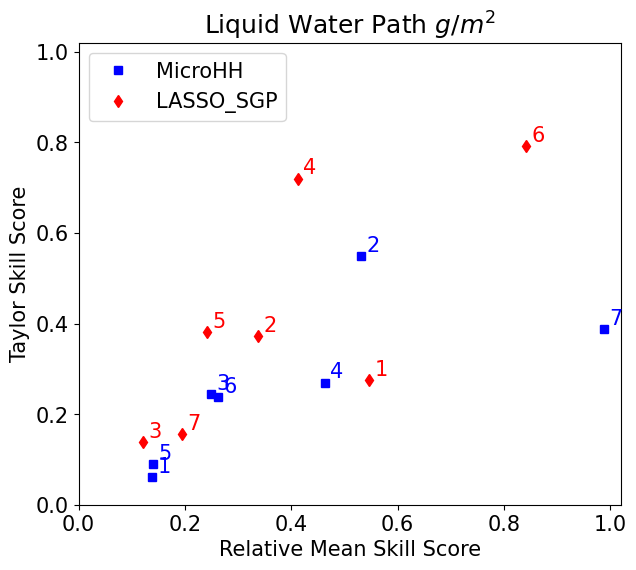

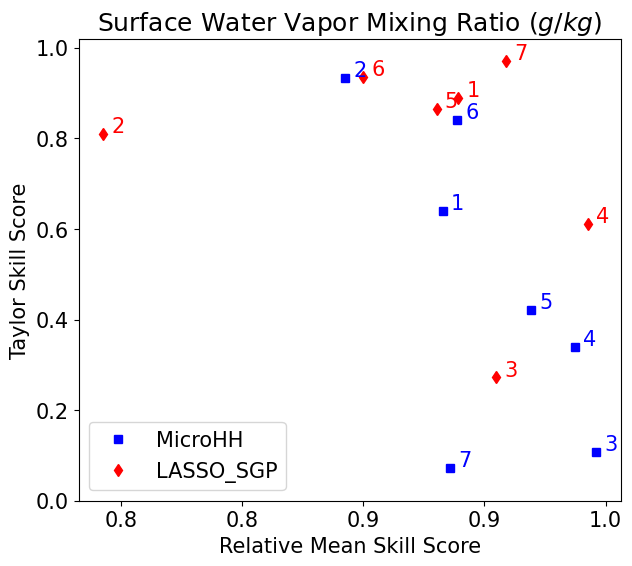

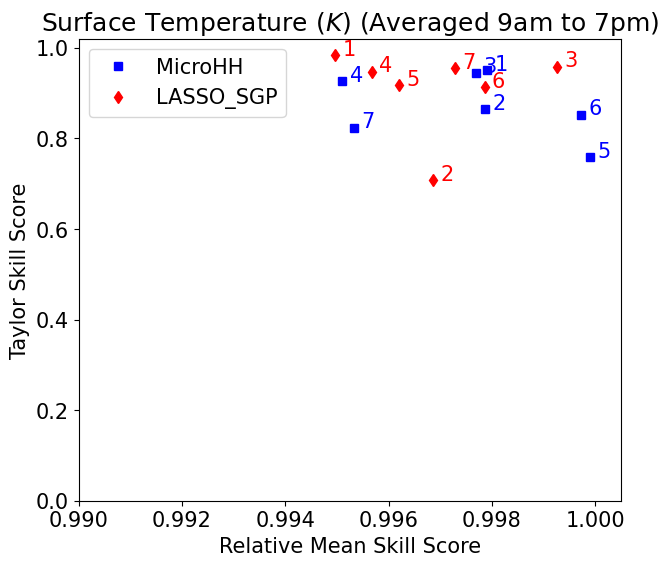

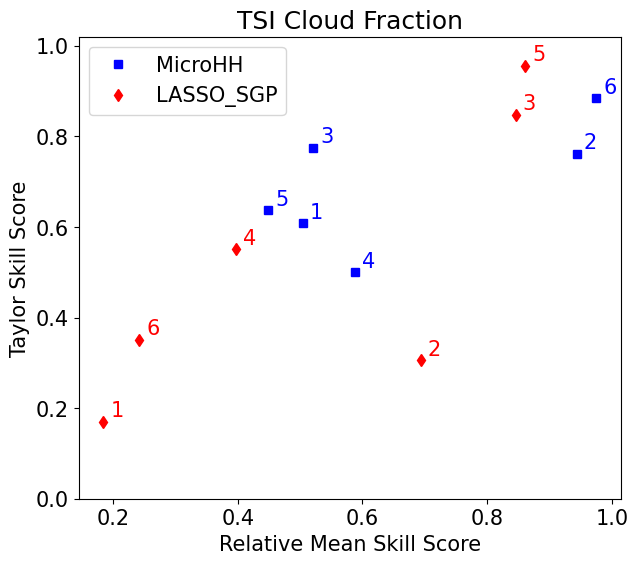

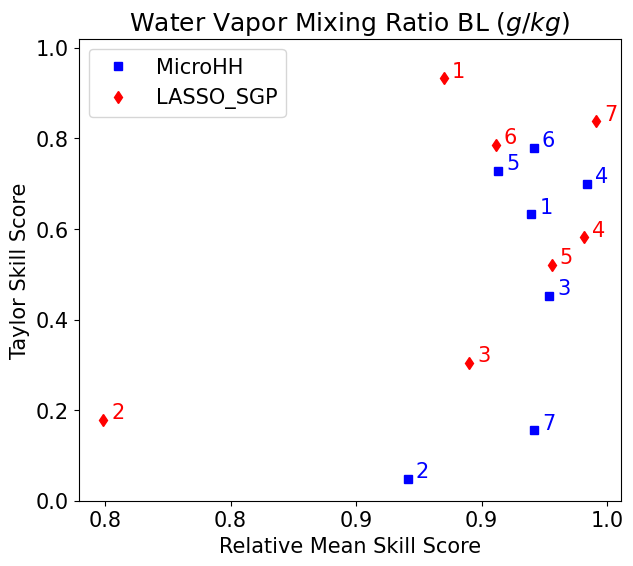

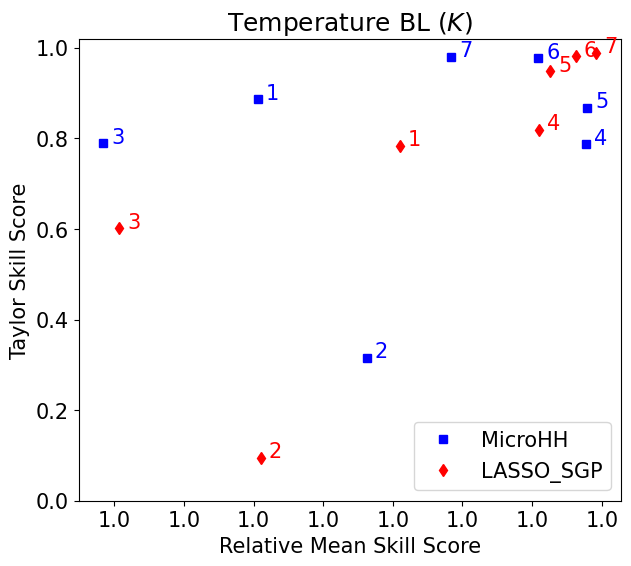

In [13]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams.update({'font.size': 15})
def scatter_figure(variable,title,legend_position):
    fig,ax = pl.subplots(figsize=(7,6))
    pl.plot(variable[2,:],variable[0,:],'bs',label='MicroHH')
    pl.plot(variable[3,:],variable[1,:],'rd',label='LASSO_SGP')
    pl.legend(loc=legend_position)
    pl.ylabel('Taylor Skill Score')
    pl.xlabel('Relative Mean Skill Score')
    pl.ylim([0,1.02])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if np.min(variable[3,:])<0.5:
        pl.xlim([0,1.02])
        an_offset = 0.01
    elif np.min(variable[3,:])>0.985:
        pl.xlim([0.99,1.0005])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        an_offset=(np.max(variable[3,:])-np.min(variable[3,:]))/30
    else:
        an_offset=(np.nanmax(variable[3,:])-np.nanmin(variable[3,:]))/60

    for i in range(0,len(variable[0,:])):
        pl.annotate(i+1, (variable[2,i],variable[0,i]),xytext=(variable[2,i]+an_offset,variable[0,i]+an_offset),color='b')

    for i in range(0,len(variable[0,:])):
        pl.annotate(i+1, (variable[3,i],variable[1,i]),xytext=(variable[3,i]+an_offset,variable[1,i]+an_offset),color='r')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join(('1 --> 2015-06-27','2 --> 2015-08-29','3 --> 2016-06-10','4 --> 2017-05-09','5 --> 2017-09-22','6 --> 2017-09-23','7 --> 2017-09-24'))
    #ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
    #        verticalalignment='top', bbox=props)
    pl.title(title)

scatter_figure(lwp_tsscore,'Liquid Water Path $g/m^2$',"upper left")
scatter_figure(qt_surf_tsscore,'Surface Water Vapor Mixing Ratio $(g/kg)$',"lower left")
scatter_figure(Ts_tsscore,'Surface Temperature $(K)$ (Averaged 9am to 7pm)',"upper left")
scatter_figure(ql_cover_tsscore,'TSI Cloud Fraction',"upper left")
scatter_figure(qt_bl_tsscore,'Water Vapor Mixing Ratio BL $(g/kg)$',"upper left")
scatter_figure(T_bl_tsscore,'Temperature BL $(K)$',"lower right")

